In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

## utils

In [0]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
      
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

## main

In [0]:
# Я не знаю, почему не читается файл, но если кто-то разберется с этим, будет СУПЕРКРУТО!

# url = 'https://raw.githubusercontent.com/RomanovIV/hse_home_projects/master/'
# with open(url+'data/data_project_2.pickle', 'rb') as f:
#     df = pickle.load(f)
# df.head()

In [4]:
!wget https://raw.githubusercontent.com/RomanovIV/hse_home_projects/master/data/data_project_2.pickle
df = pd.read_pickle('data_project_2.pickle')
print(df.shape)
df.head()

--2019-04-28 08:01:37--  https://raw.githubusercontent.com/RomanovIV/hse_home_projects/master/data/data_project_2.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48982 (48K) [application/octet-stream]
Saving to: ‘data_project_2.pickle’

data_project_2.pick 100%[===================>]  47.83K  --.-KB/s    in 0.01s   

2019-04-28 08:01:37 (3.43 MB/s) - ‘data_project_2.pickle’ saved [48982/48982]

(1094, 3)


,group,date,target
0,3,2018-03-15,1.0
1,3,2018-03-16,2.0
2,4,2018-03-16,2.0
3,3,2018-03-19,17.0
4,4,2018-03-19,19.0


In [5]:
df['group'].value_counts()

3    221
4    220
6    219
5    219
7    215
Name: group, dtype: int64

Посмотрим на ряд

(221, 4)


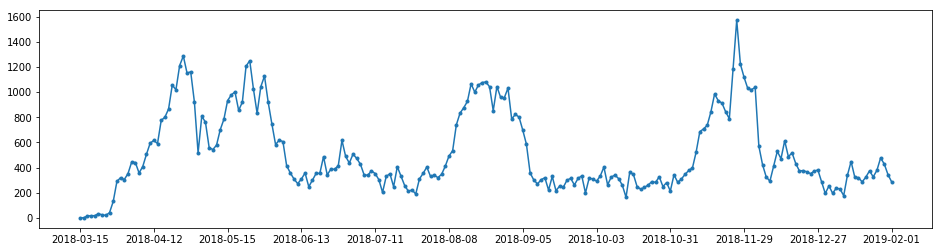

In [6]:
df_our = df[df['group']==3].reset_index()
print(df_our.shape)
plt.figure(figsize=(16,4))
plt.plot(df_our['date'], df_our['target'], marker='.')
plt.xticks(df_our['date'][::20])
plt.show()

In [7]:
dates = pd.to_datetime(df_our['date']).dt.date.values
data = df_our['target']
data.describe()

count     221.000000
mean      513.561086
std       313.225307
min         1.000000
25%       306.000000
50%       378.000000
75%       748.000000
max      1571.000000
Name: target, dtype: float64

Похоже, что ряд не является стационарным. Невооруженным глазом видны циклические изменения и отсутствие тренда.

Проверим ряд на стационарность

In [0]:
# Используем ADF и KPSS тесты

def check_stationary(_data, regression='c', conf=0.01):
    test_ADF = sm.tsa.adfuller(_data, regression=regression)
    test_KPSS = sm.tsa.kpss(_data, regression=regression)
    
    # H0: не стационарный
    print('ADF p-value: ', test_ADF[1])
    if test_ADF[1]<conf: 
        print('stationary')
    else:
        print('non-stationary')
    
    # H0: стационарный
    print('KPSS p-value: ', test_KPSS[1])
    if test_KPSS[1]<conf: 
        print('non-stationary')
    else:
        print('stationary')

In [9]:
check_stationary(data)

ADF p-value:  0.001701170595179989
stationary
KPSS p-value:  0.1
stationary


Тем не менее график говорит, что в ряде есть аддитивная цикличность. Попробуем найти период цикличности

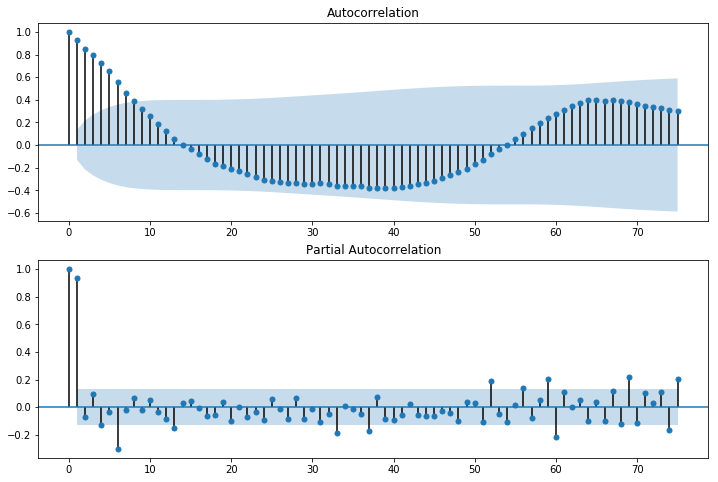

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data, lags=75, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=75, ax=ax2)

Будем считать, что период равен 60

<Figure size 432x288 with 0 Axes>

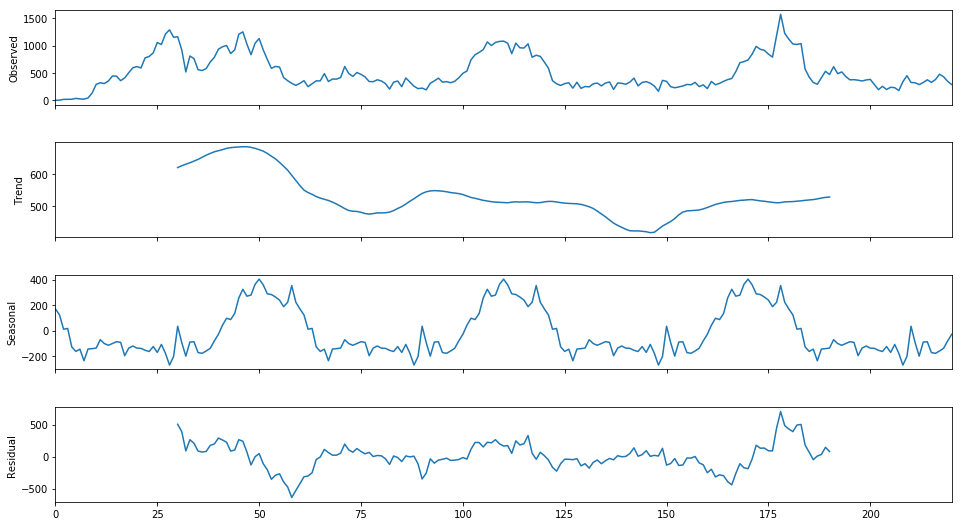

In [41]:
period = 60
decomposition = seasonal_decompose(data, model='additive', freq=period, extrapolate_trend=0)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8);

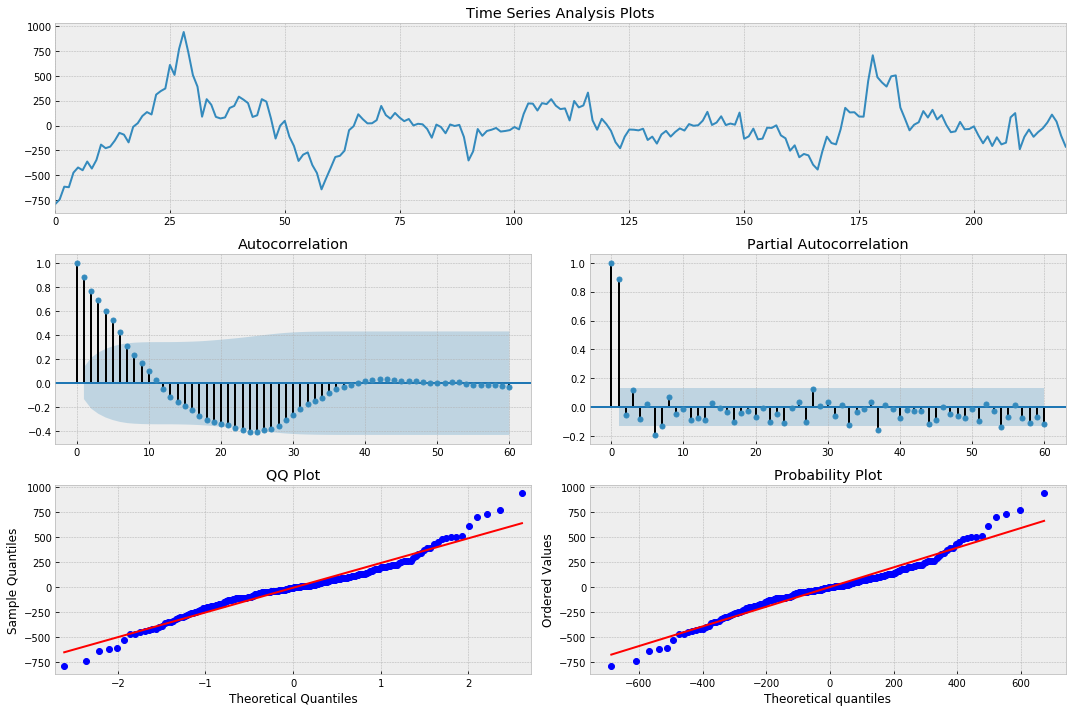

In [80]:
trend = decomposition.trend
trend[:30] = trend[30]
trend[-30:] = trend[-31:-30].values[0]
seasonal = decomposition.seasonal

data_sdecomp = data - seasonal - trend
tsplot(data_sdecomp, lags=60)

В целом выглядит неплохо, проверим ряд на стационарность

In [81]:
check_stationary(data_sdecomp)

ADF p-value:  0.0003131985593362342
stationary
KPSS p-value:  0.1
stationary


Подберем лучшую ARMA модель для полученного ряда

In [0]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    p_rng = range(2)
    q_rng = range(7)
    for i in p_rng:
        for j in q_rng:
            try:
                tmp_mdl = smt.ARMA(TS, order=(i,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
#                 print((i, j), tmp_aic)
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j)
                    best_mdl = tmp_mdl
            except: continue
    print('the best aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [102]:
_, order, model = _get_best_model(data_sdecomp)

the best aic: 2695.91209 | order: (1, 6)


In [103]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                 target   No. Observations:                  221
Model:                     ARMA(1, 6)   Log Likelihood               -1339.956
Method:                           mle   S.D. of innovations            103.485
Date:                Sun, 28 Apr 2019   AIC                           2695.912
Time:                        09:54:34   BIC                           2723.097
Sample:                             0   HQIC                          2706.889
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.target     0.7989      0.120      6.671      0.000       0.564       1.034
ma.L1.target     0.2061      0.146      1.412      0.159      -0.080       0.492
ma.L2.target     0.0120      0.148      0.08

Посмотрим на ошибки модели

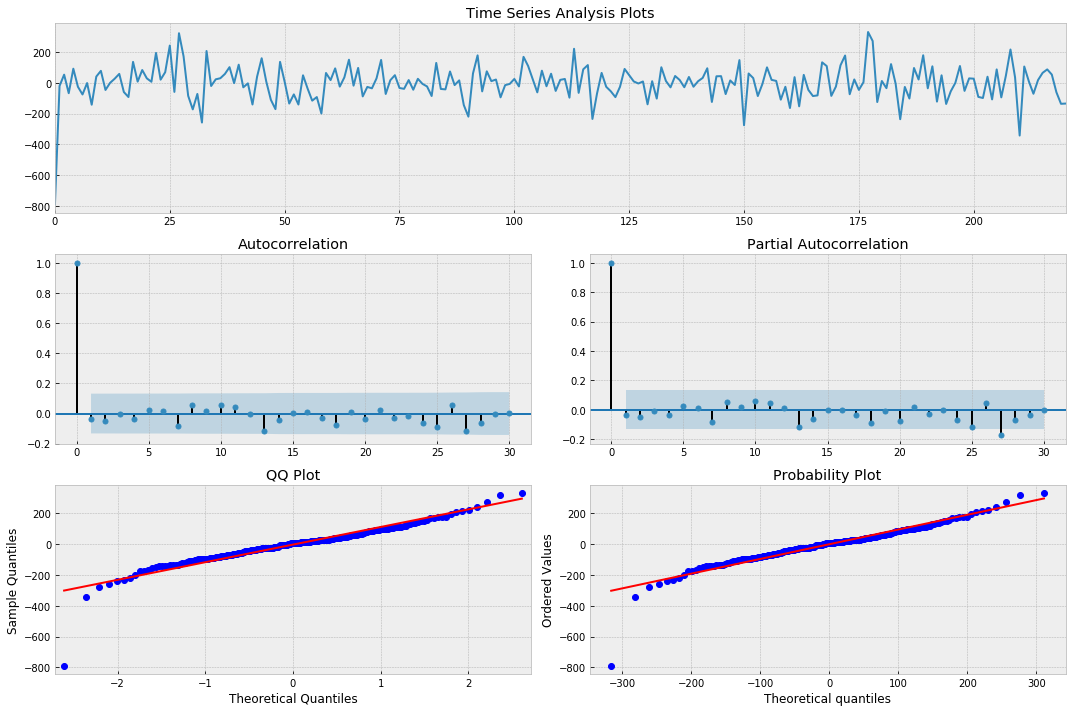

In [104]:
tsplot(model.resid, lags=30)

Все неплохо. Спрогнозируем ряд на месяц вперед

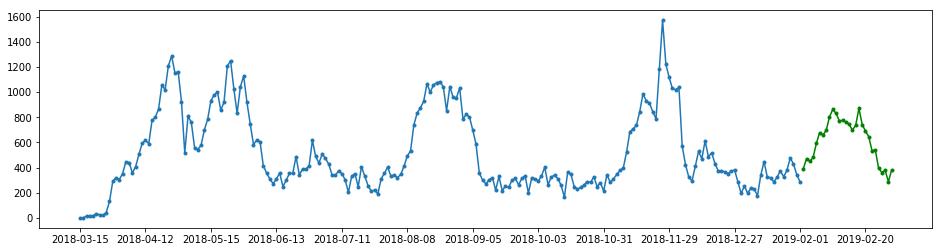

In [153]:
forecast_len = 28

ARMA_forecast, _, _ = model.forecast(forecast_len)
trend_forecast = trend[-1:].values[0]
seasonal_forecast = seasonal[-60:][:forecast_len]
forecast = ARMA_forecast + trend_forecast + seasonal_forecast

FILL_ME =  []
for i in range(1, forecast_len+1):
    FILL_ME.append('2019-02-{}'.format(i))
    
df_forecast = pd.DataFrame({'forecast': forecast, 'date': FILL_ME})
df_our_ = df_our.append(df_forecast, ignore_index=True)

plt.figure(figsize=(16,4))
plt.plot(df_our_['date'], df_our_['target'], marker='.')
plt.plot(df_our_['date'], df_our_['forecast'], marker='.', color='g')
plt.xticks(df_our_['date'][::20])
plt.show()

str